**EL MODELO EPIDEMICO DEL SIR**

Una descripción matemática simple de la propagación de una enfermedad en una población es el llamado modelo SIR, que divide la población (fija) de N individuos en tres "compartimentos" que pueden variar en función del tiempo, t:

S(t) son aquellos susceptibles pero aún no infectados con la enfermedad;
I(t) es el número de individuos infecciosos;
R(t) son aquellas personas que se han recuperado de la enfermedad y ahora tienen inmunidad.
El modelo SIR describe el cambio en la población de cada uno de estos compartimentos en términos de dos parámetros, beta y gamma.

La función de loss utilizada en el proceso de optimización fue el error cuadrático medio (RMSE).

**1. Implementar solo teniendo en cuenta los casos confirmados**

In [69]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
url = 'C:/Users/china/Downloads/Kary-Sim/Kary-Sim/who_covid_19_sit_rep_time_series.csv'

df = pd.read_csv(url)
FMT = '%m/%d/%Y'
date = df['Date']
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("3/1/2020", FMT)).days)

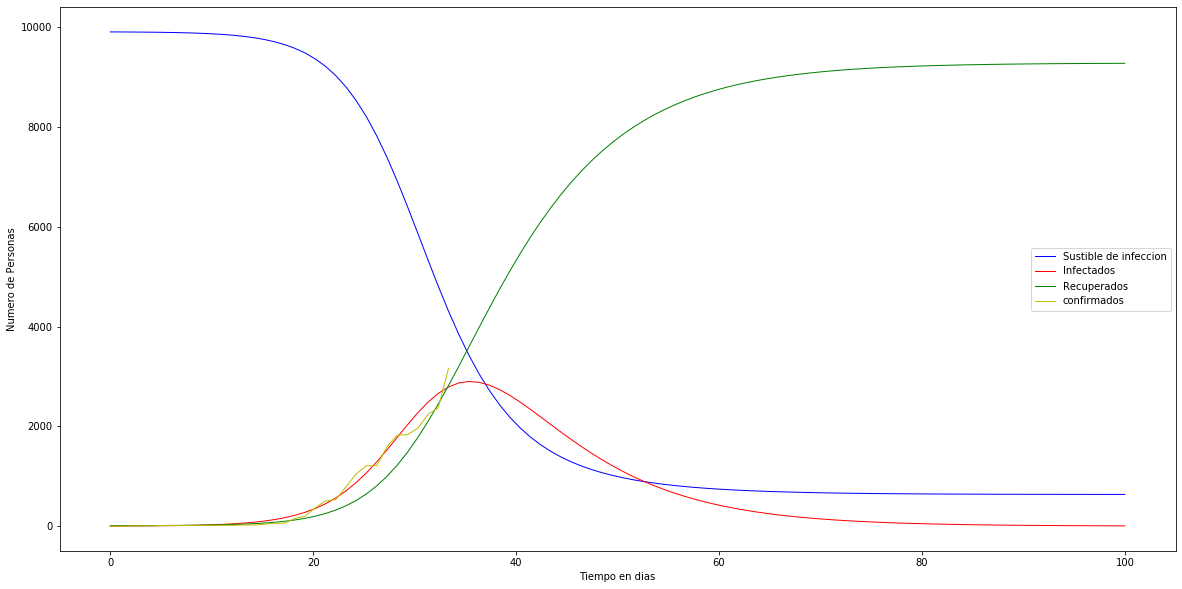

In [61]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

def loss(point, data, s0, i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))
i0=2
r0=10
s0=9909
x = np.array(df['Date'])
y = list(df.iloc [:, 1])
data=list(df.iloc [:, 1])
optimal = minimize(loss, [0.001, 0.001], args=(data,s0,i0, r0), method='L-BFGS-B', bounds=[(0.00000001,0.4), (0.00000001, 0.4)])   
beta, gamma = optimal.x
new_index =y
size = len(new_index)
ea = np.concatenate((y, [None] * (size - len(y))))
t = np.linspace(0, 100, 100)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = s0,i0,r0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(beta, gamma))
S, I, R = ret.T # Obtenicion de resultados
xa=t[0:34]
#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=1, lw=1, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=1, lw=1, label='Infectados')
ax.plot(t, R, 'g', alpha=1, lw=1, label='Recuperados')
ax.plot(xa, ea, 'y', alpha=1, lw=1, label='confirmados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')

legend = ax.legend()

**2. Implementar teniendo en cuenta los casos confirmados y recuperados.**

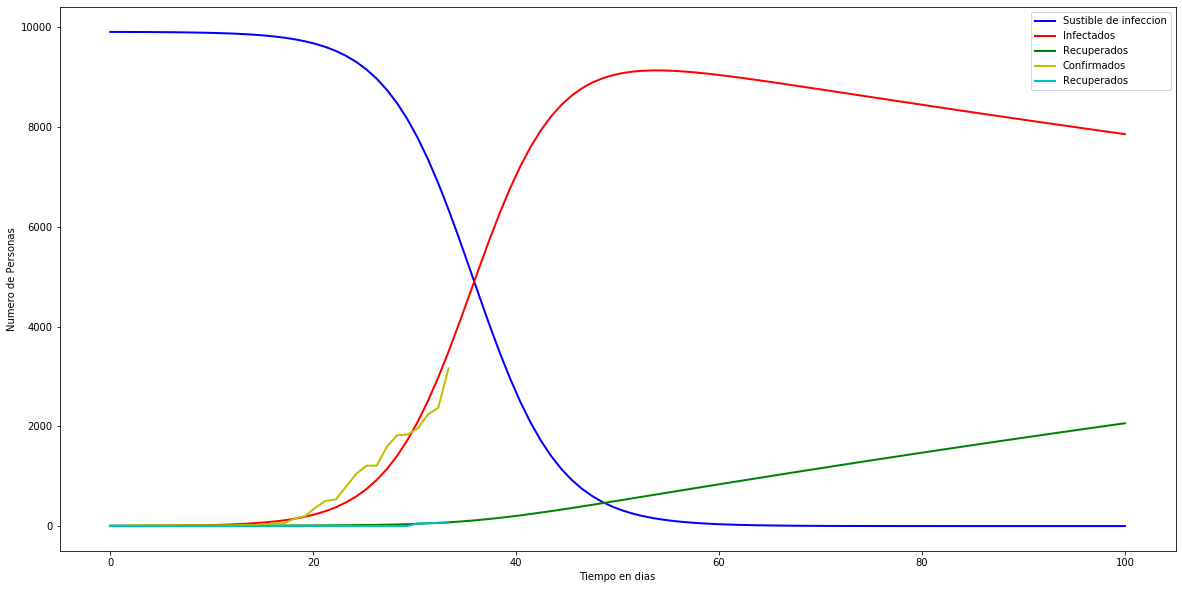

In [68]:
def loss(point, data, recovered,s0,i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha =0.1
    return alpha * l1 + (1 - alpha) * l2
i0=2
r0=10
s0=9909
recovered=list(df.iloc [:, 2])
data=list(df.iloc [:, 1])
d=[x1 - x2 for (x1, x2) in zip(data,recovered)]
optimal = minimize(loss, [0.001, 0.001], args=(d, recovered, s0, i0, i0), method='L-BFGS-B', bounds=[(0.00000001, 0.04), (0.00000001, 0.04)])
beta, gamma = optimal.x
new_index =y
size = len(new_index)
ea = np.concatenate((y, [None] * (size - len(y))))
er = np.concatenate((recovered, [None] * (size - len(recovered))))
xa=t[0:34]

t = np.linspace(0, 100,100)
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I- gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
# Vector de condiciones iniciales
y0 = s0,i0,r0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(beta, gamma))
S, I, R = ret.T # Obtenicion de resultados
#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=1, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=1, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=1, lw=2, label='Recuperados')
ax.plot(xa, y, 'y', alpha=1, lw=2, label='Confirmados')
ax.plot(xa, er, 'c', alpha=1, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
legend = ax.legend()

**TASA DE INCIDENCIA**

In [77]:
##Numero de casos nuevos ocurridos en el lugar
NumC=df.iloc [:, 1]
##Total de la poblacion
NP=17023000
##Incidencia
##(pow(10,4)) tasa de mortalidad por infección de 2 a 5
IC=((NumC/NP)*pow(10,4))
print(IC)

0     0.000587
1     0.000587
2     0.003525
3     0.004112
4     0.004112
5     0.007637
6     0.008224
7     0.008224
8     0.008812
9     0.008812
10    0.008812
11    0.009986
12    0.009986
13    0.013511
14    0.013511
15    0.021735
16    0.034072
17    0.034072
18    0.091053
19    0.116901
20    0.215591
21    0.297245
22    0.312518
23    0.464078
24    0.616225
25    0.711390
26    0.711390
27    0.936968
28    1.070904
29    1.077953
30    1.152558
31    1.315867
32    1.393409
33    1.858074
Name: Cases, dtype: float64


In [80]:
import statistics as st
##Tasa de prevalencia
T=df.iloc [:, 0]
TS=IC*st.median(T)
print(TS)

0      0.009693
1      0.009693
2      0.058157
3      0.067849
4      0.067849
5      0.126006
6      0.135699
7      0.135699
8      0.145392
9      0.145392
10     0.145392
11     0.164777
12     0.164777
13     0.222934
14     0.222934
15     0.358632
16     0.562181
17     0.562181
18     1.502379
19     1.928861
20     3.557246
21     4.904541
22     5.156553
23     7.657287
24    10.167714
25    11.737943
26    11.737943
27    15.459966
28    17.669917
29    17.786230
30    19.017212
31    21.711802
32    22.991247
33    30.658227
Name: Cases, dtype: float64
